<a href="https://colab.research.google.com/github/ritwiks9635/Enhancement-Model/blob/main/Image_Colorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import cv2
from glob import glob
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Input, Conv2D, BatchNormalization, UpSampling2D, Concatenate, MaxPooling2D
from keras.models import Model
from keras.regularizers import l2
from keras.utils import plot_model

import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings("ignore")

In [2]:
kkr = "/content/art-colorization-dataset/train"
total_img = sorted([os.path.join(kkr, file) for file in os.listdir(kkr)])
split_idx = int(len(total_img) * 0.8)

train_img = total_img[: split_idx]
val_img = total_img[split_idx :]

print(f"Total train Image is {len(train_img)}")
print(f"Total Valid Image is {len(val_img)}")

Total train Image is 1617
Total Valid Image is 405


(256, 256, 3)
(256, 256)


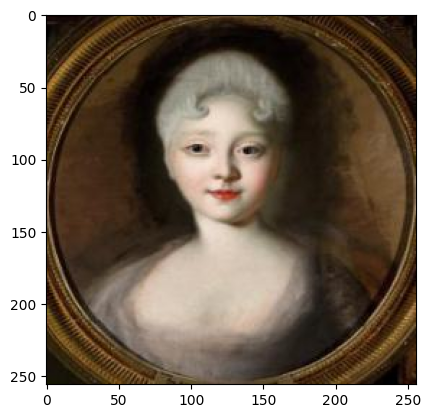

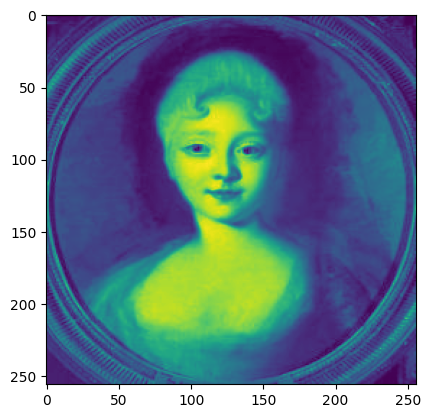

In [4]:
img = cv2.imread(total_img[56])
O_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
G_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
print(O_img.shape)
print(G_img.shape)
plt.imshow(O_img)
plt.show()

plt.imshow(G_img)
plt.show()

In [5]:
def data_generator(img_path, convert_to_gray=False):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_png(img, channels=3)
    img.set_shape([None, None, 3])
    img = tf.image.resize(img, size=[256, 256])

    if convert_to_gray:
        img = tf.image.rgb_to_grayscale(img)

    img = img / 255.0
    return img


def dataloader(rgb_img_path):
    # Generate grayscale from the RGB image
    gray_img = data_generator(rgb_img_path, convert_to_gray=True)
    # Load the original RGB image
    rgb_img = data_generator(rgb_img_path, convert_to_gray=False)
    return gray_img, rgb_img


def build_dataset(rgb_img_paths, batch_size=4, augment=True):
    dataset = tf.data.Dataset.from_tensor_slices(rgb_img_paths)
    dataset = dataset.map(dataloader, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size=100)  # Shuffle for training
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset


# Example of creating train and validation datasets
train_dataset = build_dataset(train_img, batch_size=4)
val_dataset = build_dataset(val_img, batch_size=4)

In [6]:
print(train_dataset)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None))>


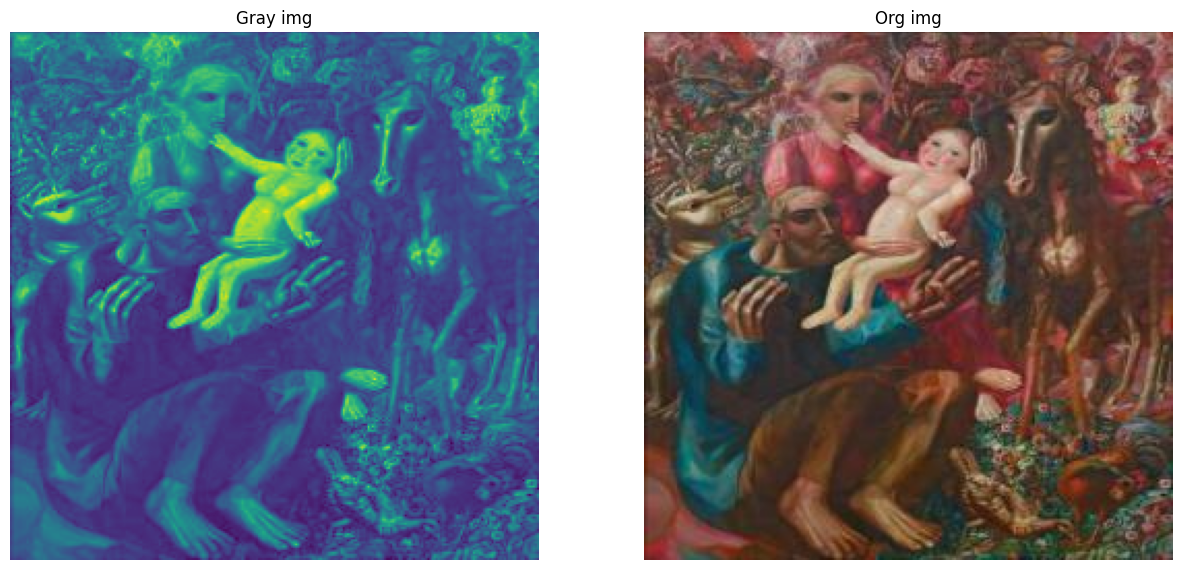

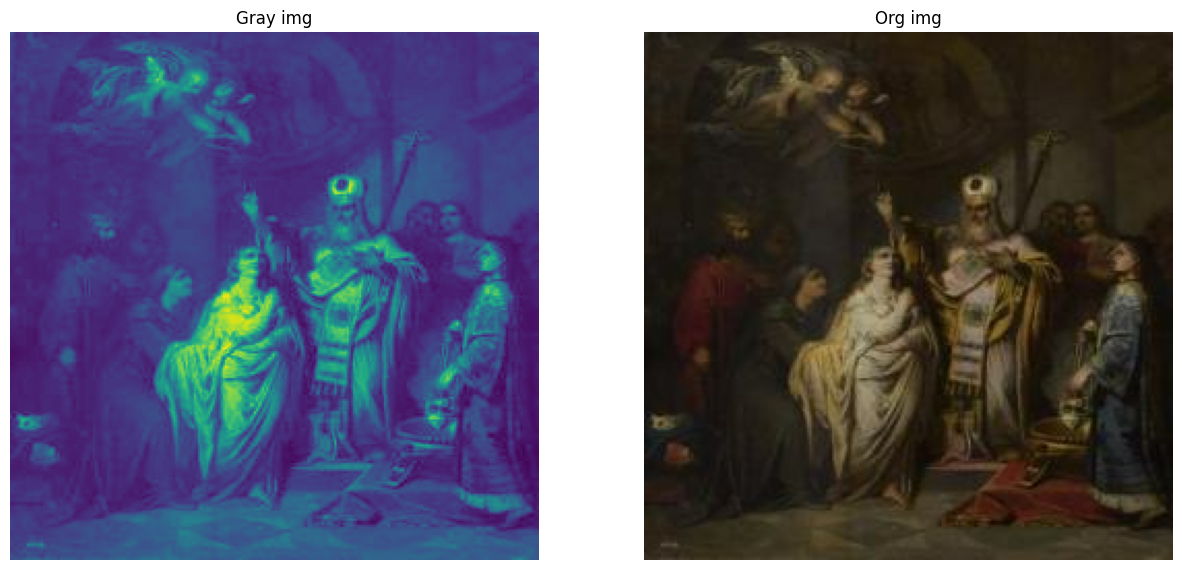

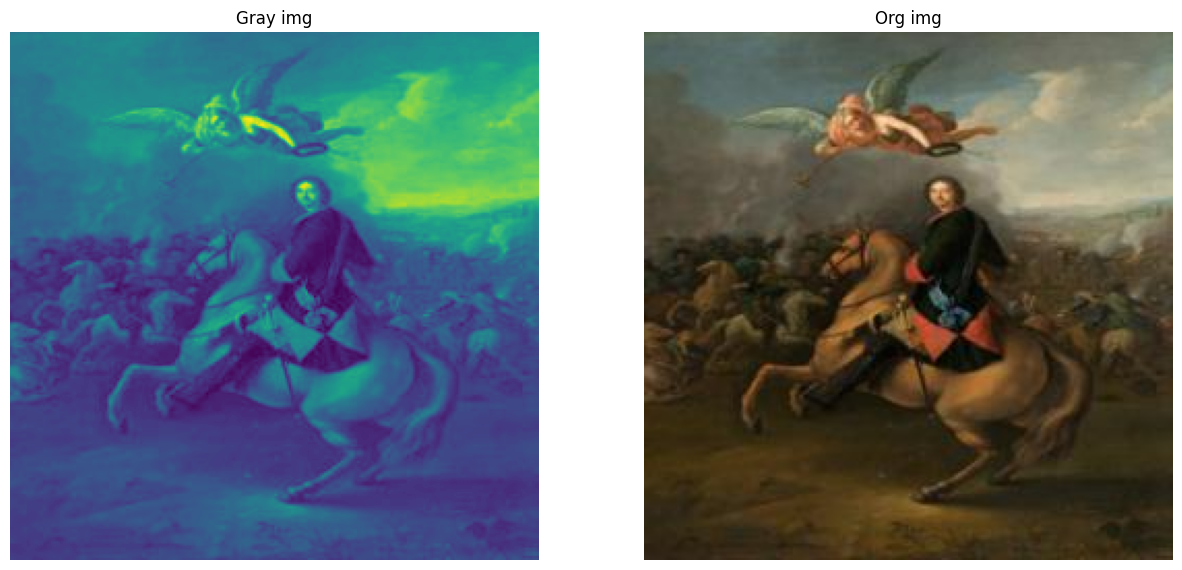

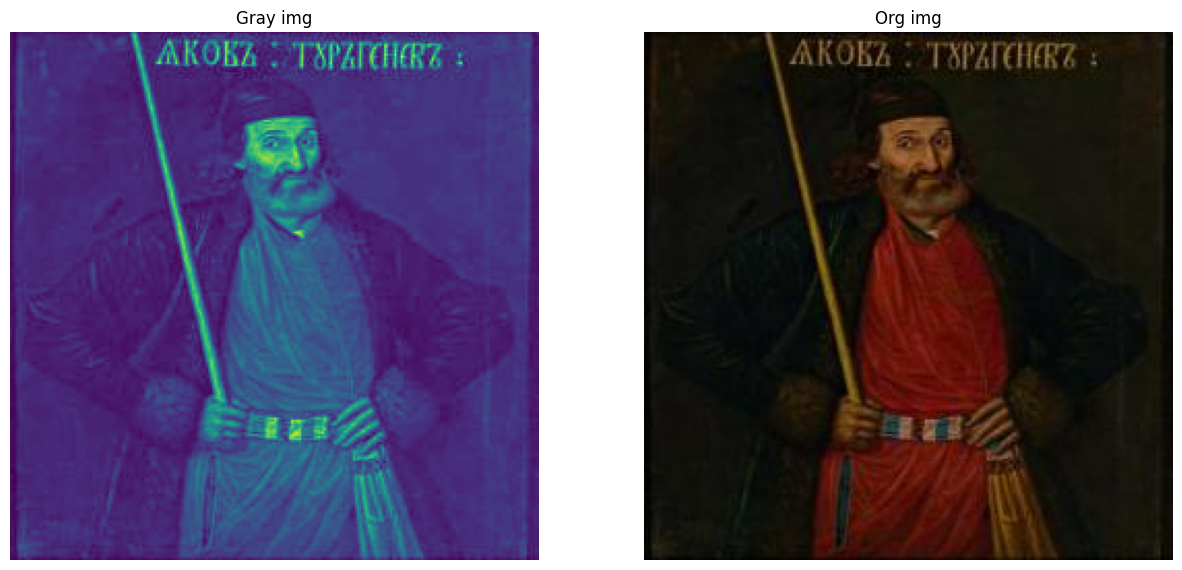

In [10]:
def display_input(Gray, Org):
    plt.figure(figsize=(15, 15))
    display = [Gray[0], Org[0]]
    title = ["Gray img", "Org img"]
    for i in range(2):
        plt.subplot(1, 2, i + 1)
        plt.imshow(display[i])
        plt.title(title[i])
        plt.axis("off")
    plt.show()


for Gray, Org in train_dataset.take(4):
    display_input(Gray, Org)

In [10]:
from tensorflow.keras.applications import VGG16

def build_model_with_pretrained_encoder():

    pretrained_model = VGG16(include_top=False, input_shape=(256, 256, 3))
    for layer in pretrained_model.layers:
        layer.trainable = False

    # Input Layer
    input_tensor = Input(shape=(256, 256, 1))

    # Convert Grayscale to RGB
    x = Conv2D(3, (3, 3), padding='same', activation='relu', name="grayscale_to_rgb")(input_tensor)

    # Encoder (VGG16)
    x = pretrained_model(x)

    # Decoder
    # Upsample from 8x8 to 256x256
    x = UpSampling2D(size=(2, 2), name="upsample1")(x)  # 8x8 -> 16x16
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name="conv1")(x)
    x = BatchNormalization(name="bn1")(x)

    x = UpSampling2D(size=(2, 2), name="upsample2")(x)  # 16x16 -> 32x32
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name="conv2")(x)
    x = BatchNormalization(name="bn2")(x)

    x = UpSampling2D(size=(2, 2), name="upsample3")(x)  # 32x32 -> 64x64
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name="conv3")(x)
    x = BatchNormalization(name="bn3")(x)

    x = UpSampling2D(size=(2, 2), name="upsample4")(x)  # 64x64 -> 128x128
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name="conv4")(x)
    x = BatchNormalization(name="bn4")(x)

    x = UpSampling2D(size=(2, 2), name="upsample5")(x)  # 128x128 -> 256x256
    x = Conv2D(32, (3, 3), activation='relu', padding='same', name="conv5")(x)
    x = BatchNormalization(name="bn5")(x)

    # Final Output Layer
    outputs = Conv2D(3, (1, 1), activation='tanh', padding='same', name='predicted_rgb')(x)

    # Build Model
    model = Model(inputs=input_tensor, outputs=outputs, name="ColorizationModelWithPretrainedEncoder")
    return model

# Build and summarize the model
my_model = build_model_with_pretrained_encoder()
my_model.summary()

Model: "ColorizationModelWithPretrainedEncoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 256, 256, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ grayscale_to_rgb (Conv2D)            │ (None, 256, 256, 3)         │              30 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 8, 8, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ upsample1 (UpSampling2D)             │ (None, 16, 16, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn1 (BatchNormalization)             │ (None, 16, 16, 512)         │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ upsample2 (UpSampling2D)             │ (None, 32, 32, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2 (Conv2D)                       │ (None, 32, 32, 256)         │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn2 (BatchNormalization)             │ (None, 32, 32, 256)         │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ upsample3 (UpSampling2D)             │ (None, 64, 64, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3 (Conv2D)                       │ (None, 64, 64, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn3 (BatchNormalization)             │ (None, 64, 64, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ upsample4 (UpSampling2D)             │ (None, 128, 128, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv4 (Conv2D)                       │ (None, 128, 128, 64)        │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn4 (BatchNormalization)             │ (None, 128, 128, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ upsample5 (UpSampling2D)             │ (None, 256, 256, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv5 (Conv2D)                       │ (None, 256, 256, 32)        │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn5 (BatchNormalization)             │ (None, 256, 256, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ predicted_rgb (Conv2D)               │ (None, 256, 256, 3)         │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,645,793 (71.13 MB)

 Trainable params: 3,929,121 (14.99 MB)

 Non-trainable params: 14,716,672 (56.14 MB)

In [13]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.losses import MeanSquaredError

vgg = VGG19(include_top=False, input_shape=(256, 256, 3))
vgg.trainable = False
feature_extractor = Model(inputs=vgg.input, outputs=vgg.get_layer('block5_conv2').output)

# Define Perceptual Loss
def perceptual_loss(y_true, y_pred):
    y_true_features = feature_extractor(y_true)
    y_pred_features = feature_extractor(y_pred)
    mse = MeanSquaredError()
    return mse(y_true_features, y_pred_features)

In [19]:
my_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=perceptual_loss,
    metrics=['accuracy', 'mean_absolute_error']
)

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

def get_callbacks():
    callbacks = [
        #TensorBoard(log_dir="./logs", histogram_freq=1, write_graph=True),
        ModelCheckpoint("colorization_model.keras", monitor="val_loss", save_best_only=True, verbose=1),
        #ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1),
        EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, verbose=1)
    ]
    return callbacks

# Get the callbacks
callbacks = get_callbacks()
history = my_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20
405/405 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.2197 - loss: 0.5304 - mean_absolute_error: 0.5649
Epoch 1: val_loss improved from inf to 0.35843, saving model to colorization_model.keras
405/405 ━━━━━━━━━━━━━━━━━━━━ 112s 252ms/step - accuracy: 0.2197 - loss: 0.5302 - mean_absolute_error: 0.5648 - val_accuracy: 0.1337 - val_loss: 0.3584 - val_mean_absolute_error: 0.5105
Epoch 2/20
405/405 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.0892 - loss: 0.3240 - mean_absolute_error: 0.4442
Epoch 2: val_loss improved from 0.35843 to 0.28254, saving model to colorization_model.keras
405/405 ━━━━━━━━━━━━━━━━━━━━ 132s 240ms/step - accuracy: 0.0891 - loss: 0.3240 - mean_absolute_error: 0.4441 - val_accuracy: 0.0558 - val_loss: 0.2825 - val_mean_absolute_error: 0.3122
Epoch 3/20
405/405 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.0498 - loss: 0.2638 - mean_absolute_error: 0.2851
Epoch 3: val_loss improved from 0.28254 to 0.27171, saving model to colorization_model.keras
4

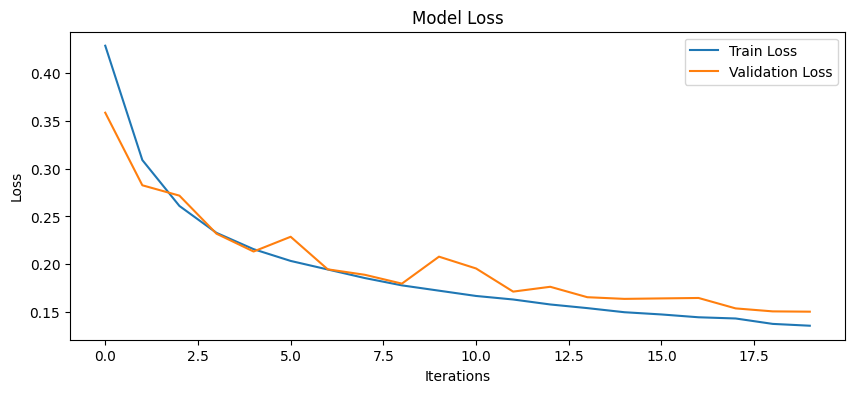

In [20]:
history = history.history


plt.figure(figsize=(10,4))
plt.plot(history["loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.title("Model Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [21]:
my_model.load_weights("/content/colorization_model.keras")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


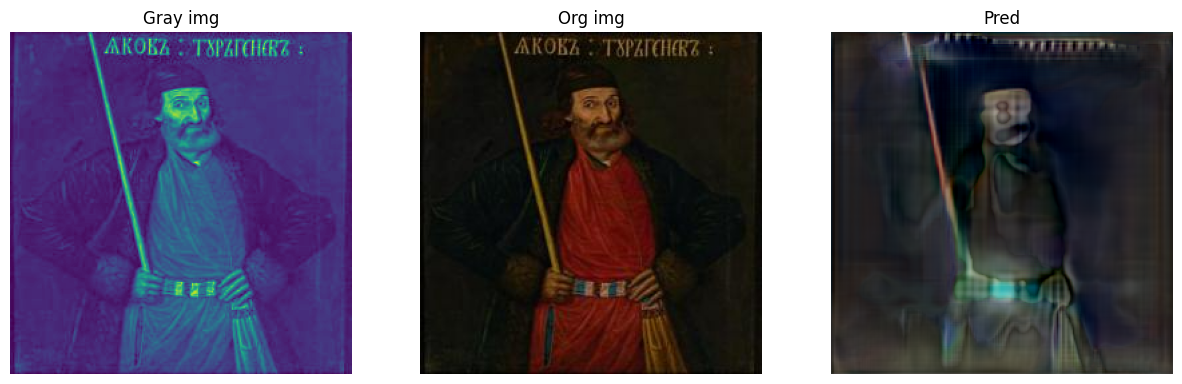

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


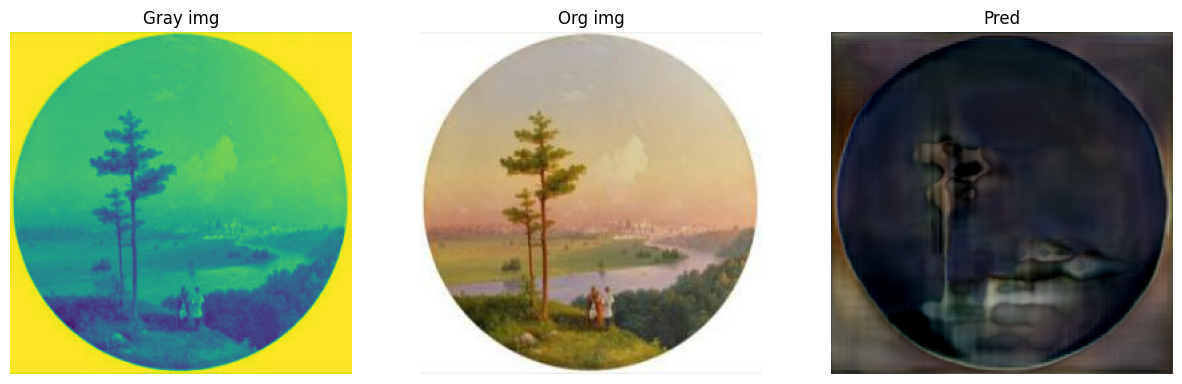

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


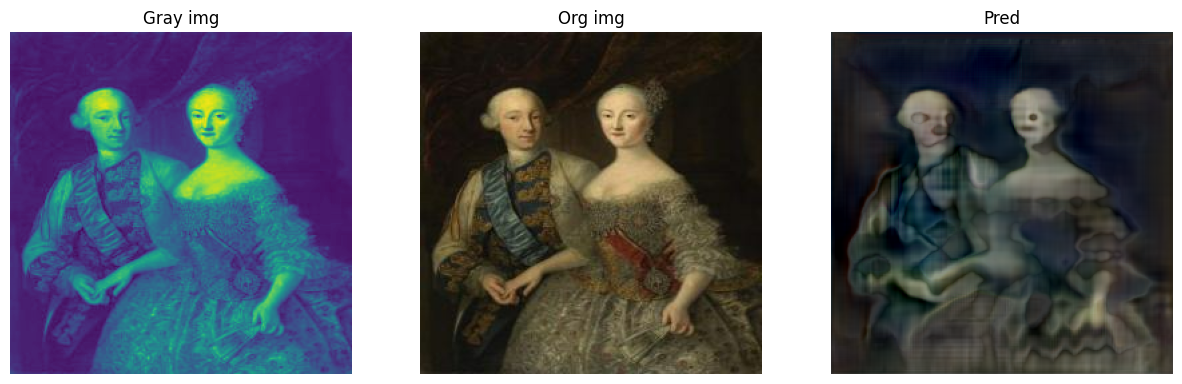

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


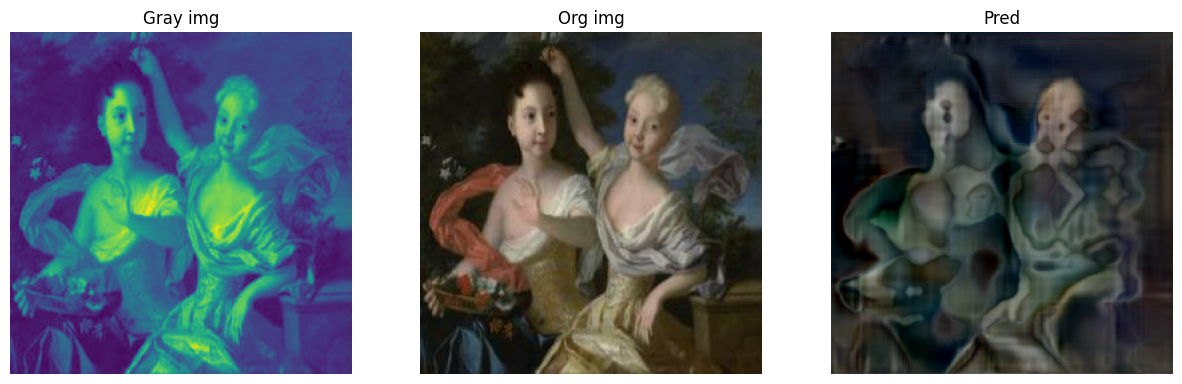

In [22]:
def display_input(Model, Gray, Org):
    pred = Model.predict(Gray)
    plt.figure(figsize=(15, 15))
    display = [Gray[0], Org[0], pred[0]]
    title = ["Gray img", "Org img", "Pred"]
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.imshow(display[i])
        plt.title(title[i])
        plt.axis("off")
    plt.show()


for Gray, Org in train_dataset.take(4):
    display_input(my_model, Gray, Org)